# 频率匹配方法（Frequency-matching method）

#### —— 数值模式降水系统性偏差订正技术

国家气象中心天气预报技术研发室  
代刊, 王玉, 唐健, June, 2021  


#### Objectives
* 了解频率匹配方法的原理；
* 掌握频率匹配方法中观测和预报累积概率密度曲线CDF如何构建；
* 掌握如何利用CDF进行降水偏差订正；
* 了解频率匹配方法的业务实际应用；
* 了解分位值映射方法；

---

In [1]:
# set up things
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [11]:
# load necessary libraries
# you should install cartopy with 'conda install -c conda-forge cartopy'
import sys
import pickle
from pathlib import Path
import xarray as xr
import numpy as np
import pandas as pd
import cartopy.crs as ccrs
import matplotlib as mpl
import matplotlib.pyplot as plt

from nmc_met_base.qpf_cal import cum_freq, cfd_match

##  频率匹配方法原理
---

由于降水具有非高斯分布特征，其系统性误差并不能通过观测与预报之间的差值直接订正。为此，朱跃建(2015)发展了频率匹配方法，通过改变降水预报量值，使得预报的降水频率分布向观测频率靠拢。具体步骤分为两步：

* 第一步，需要采用训练数据集构建不同百分位预报值$F$的累积频率分布曲线$FCDF$和相应的观测累积频率分布$OCDF$。
* 第二步，预报调整，即对预报值进行替换，使得CDF曲线上预报与观测的频率值的相同。

<img src="./images/freq_match_01.png" alt="image" style="height: 350px;">

## 构建累积频率分布曲线
---

* 累积频率分布曲线的构建方法为，预先给定一系列升序排列的降水阈值，然后针对每个阈值计算某区域内，超过该阈值的预报或观测样本数所占总样本数据的比例，得到该阈值的累积频率值CDF，连接阈值序列的CDF即可得到累积频率分布曲线CDFs。
* CDFs的形状与气候背景关系密切，为反映CDFs的区域性特点，但同时保证降水事件的数量（尤其是大量级降水事件）不会太低。

### 对比站点的观测与预报不同等级降水的发生频率

* `./samples/station_obs_fcst/`目录下放置了北京、上海、广州、成都站及其相似站点的预报和观测实况数据；
* 数据存放方式为：一个点/起报时刻/预报时效一个文件，时间段为2019年6月1日至8月31日；
* 读入统一个预报时效的所有数据，构建样本集放入Pandas表格
* 下面以北京站为例，对比观测和预报的不同等级降水发生频率

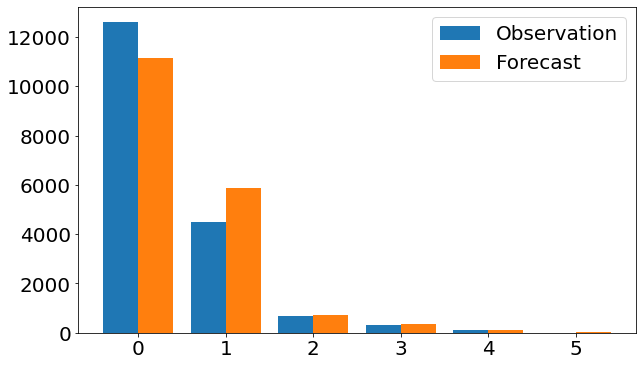

In [3]:
#
# retrieve observation and forecast data
datafiles = Path("./samples/station_obs_fcst/beijing/").glob("*_024.txt")
data = pd.DataFrame()
for datafile in datafiles:
    tmp = pd.read_csv(datafile)
    data = pd.concat([data, tmp], axis=0, ignore_index=True)
data.columns = [s.strip() for s in data.columns]
data['OBS'] = data['OBS'].astype(float)
data['FCST'] = data['FCST'].astype(float)

# compare the frequency of obs and forecast
bins = [0,0.1,10,25,50,100,250]
obs_hist, _ = np.histogram(data['OBS'], bins=bins)
fct_hist, _ = np.histogram(data['FCST'], bins=bins)

plt.figure(figsize=(10,6))
plt.rcParams.update({"font.size":20})
plt.bar(np.arange(len(bins)-1)-0.2, obs_hist, 0.4, label="Observation")
plt.bar(np.arange(len(bins)-1)+0.2, fct_hist, 0.4, label="Forecast")
plt.legend()
plt.show()

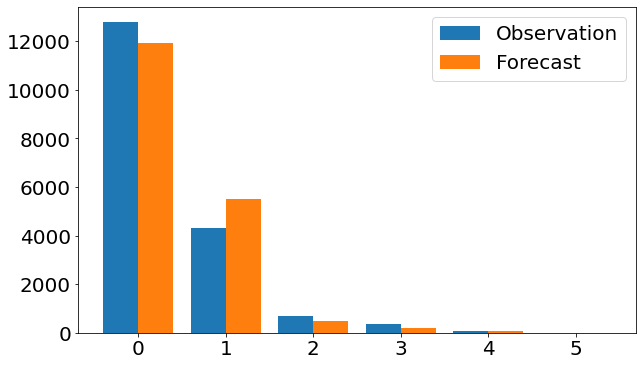

In [4]:
#
# retrieve observation and forecast data
datafiles = Path("./samples/station_obs_fcst/beijing/").glob("*_144.txt")
data = pd.DataFrame()
for datafile in datafiles:
    tmp = pd.read_csv(datafile)
    data = pd.concat([data, tmp], axis=0, ignore_index=True)
data.columns = [s.strip() for s in data.columns]
data['OBS'] = data['OBS'].astype(float)
data['FCST'] = data['FCST'].astype(float)

# compare the frequency of obs and forecast
bins = [0,0.1,10,25,50,100,250]
obs_hist, _ = np.histogram(data['OBS'], bins=bins)
fct_hist, _ = np.histogram(data['FCST'], bins=bins)

plt.figure(figsize=(10,6))
plt.rcParams.update({"font.size":20})
plt.bar(np.arange(len(bins)-1)-0.2, obs_hist, 0.4, label="Observation")
plt.bar(np.arange(len(bins)-1)+0.2, fct_hist, 0.4, label="Forecast")
plt.legend()
plt.show()

<div class="alert alert-success">
    <b>EXERCISE</b>:
    对比分析不同站点、不同时效的降水出现频率:
     <ul>
      <li>对比不同站点、不同等级的观测、预报降水出现频率.</li>
      <li>对比24h、96h、168h、240h时效，不同等级的观测、预报降水出现频率.</li>
    </ul>
</div>

<div class="alert alert-info">
    <b>SOLUTION</b>
</div>

### 构建累积概率分布函数

<div class="alert alert-success">
    <b>EXERCISE</b>:
    累积概率分布函数的构建和分析:
     <ul>
      <li>构建累积概率分布函数程序"cum_freq".</li>
      <li>对比分析不同站点、不同时效的观测和预报累积概率分布曲线.</li>
    </ul>
</div>

<div class="alert alert-info">
    <b>SOLUTION</b>
</div>

```python
def cum_freq(data, bins=None, norm=True):
    """Calculate the cumulative frequency distribution.

    Arguments:
        data {numpy nd-array} -- numpy nd-array. The missing value is allowed.

    Keyword Arguments:
        bins {numpy array} -- the bin-edegs used to calculate CFD.
        norm {bool} -- normalize the distribution (default: {True})
    """

    # set the bin edges
    if bins is None:
        bins = np.concatenate(([0.1, 1], np.arange(2, 10, 1),
                               np.arange(10, 152, 2)))

    # TO Do, complete the code

    # return the bin edges and CFD
    return cfd_array, bins
```

In [5]:
#
# retrieve observation and forecast data
datafiles = Path("./samples/station_obs_fcst/guangzhou/").glob("*_048.txt")
data = pd.DataFrame()
for datafile in datafiles:
    tmp = pd.read_csv(datafile)
    data = pd.concat([data, tmp], axis=0, ignore_index=True)
data.columns = [s.strip() for s in data.columns]
data['OBS'] = data['OBS'].astype(float)
data['FCST'] = data['FCST'].astype(float)

In [8]:
#
# calculate the CFD
obs_cfd, bins = cum_freq(data['OBS'])
fct_cfd, bins = cum_freq(data['FCST'])

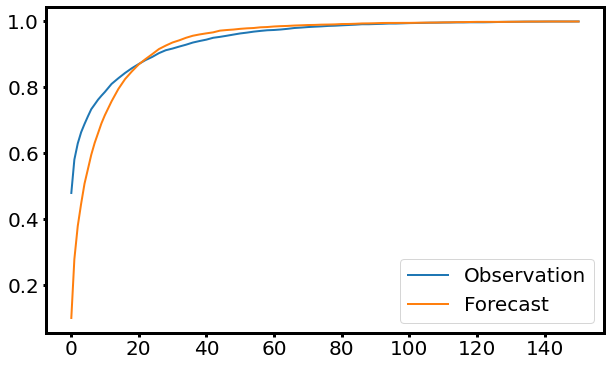

In [9]:
#
# Compare the Observation and Forecasting CFD
plt.figure(figsize=(10,6))
plt.rcParams.update({"font.size":20, "axes.linewidth":3, "xtick.major.width":3, "ytick.major.width":3})
plt.plot(bins, obs_cfd, label="Observation", linewidth=2)
plt.plot(bins, fct_cfd, label="Forecast", linewidth=2)
plt.legend()
plt.show()

## 基于CFD曲线进行预报调整
---

* 对于一个原始预报值“RAW”可以通过预报频率分布曲线（实线）获得出现频率值，为保证预报与观测具有相同频率分布，则在观测频率分布曲线（虚线）上找到同样频率的位置，其对应的观测量级即为订正后的预报值“CAL”。通过此方法，可以看到在“RAW”值上预报频率高于观测（过度预报），通过频率匹配订正可以适当减小预报量级。

<div class="alert alert-success">
    <b>EXERCISE</b>:
    进行预报调整:
     <ul>
      <li>构建累积概率分布函数匹配调整程序"cfd_match".</li>
      <li>对某个城市、某个时效的预报量进行CFD匹配调整，使得观测与预报的CFD一致.</li>
    </ul>
</div>

<div class="alert alert-info">
    <b>SOLUTION</b>
</div>

```python
def cfd_match(data, cfd_obs, cfd_fcst, bins):
    """
    Perform the frequency-matching methods.

    Args:
        data (np.array): forecast data to be calibrated.
        cdf_obs (np.array): 1D array, the cumulative frequency distribution of observations.
        cdf_fcst (np.array): 1D array, the cumulative frequency distribution of forecasts.
        bins (np.array): 1D array, bin edges for CFD.

    Returns:
        np.array: calibrated forecasts.
    """

    # To DO, complete the code
    
    return data_cal
```

In [12]:
#
# retrieve observation and forecast data
datafiles = Path("./samples/station_obs_fcst/guangzhou/").glob("*_048.txt")
data = pd.DataFrame()
for datafile in datafiles:
    tmp = pd.read_csv(datafile)
    data = pd.concat([data, tmp], axis=0, ignore_index=True)
data.columns = [s.strip() for s in data.columns]
data['OBS'] = data['OBS'].astype(float)
data['FCST'] = data['FCST'].astype(float)

假定预报值为`[0, 0.1, 2, 6, 15, 52, 100, 130, 203.]`，计算订正后的降水值

In [14]:
with np.printoptions(precision=3, suppress=True):
    print(cfd_match([0, 0.1, 2, 6, 15, 52, 100, 130, 203.], obs_cfd, fct_cfd, bins))

[  0.      0.1     0.1     1.305  11.978  65.2   104.    130.667 203.   ]


对预报值进行频率匹配调整，并对比调整后的预报和观测的CFD

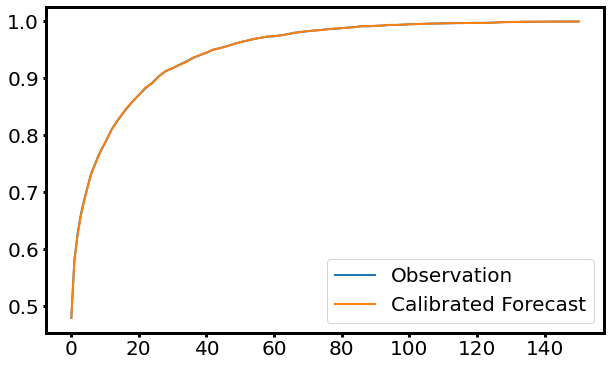

In [16]:
#
# retrieve observation and forecast data
datafiles = Path("./samples/station_obs_fcst/guangzhou/").glob("*_048.txt")
data = pd.DataFrame()
for datafile in datafiles:
    tmp = pd.read_csv(datafile)
    data = pd.concat([data, tmp], axis=0, ignore_index=True)
data.columns = [s.strip() for s in data.columns]
data['OBS'] = data['OBS'].astype(float)
data['FCST'] = data['FCST'].astype(float)

# adjust the forecast values
fct_cal = cfd_match(data['FCST'], obs_cfd, fct_cfd, bins)

# calculate the calibrated forecast and observation CFD
obs_cfd, bins = cum_freq(data['OBS'])
fct_cal_cfd, bins = cum_freq(fct_cal)

# Compare
plt.figure(figsize=(10,6))
plt.rcParams.update({"font.size":20, "axes.linewidth":3, "xtick.major.width":3, "ytick.major.width":3})
plt.plot(bins, obs_cfd, label="Observation", linewidth=2)
plt.plot(bins, fct_cal_cfd, label="Calibrated Forecast", linewidth=2)
plt.legend()
plt.show()

## 分位值映射(Quantile Mapping)
---

分位值映射是另一种较为常用的降水量级订正方法，不仅用于天气模式（Bremnes，2007），也多用于气候模式（Maraun，2013）。分位值映射具有与频率匹配方法相同的两个步骤，主要不同点在于其采用降水样本的分位值分布曲线。Maraun（2013）指出当观测数据的分辨率远高于预报数据时，分位值映射还起到将低分辨预报转换为高分辨率的功能，但该降尺度作用会使得校正后降水序列的时空结构歪曲（如区域平均的极端值被过高估计，降水变化趋势受到影响等）；为避免这些问题，需要加入随机偏差订正。Cannon等（2015）进一步引入分位差值映射来确保订正后降水时间序列的变化趋势不变，并将单变量的分位值映射拓展到多变量（降水和温度）协同订正。Hamill等（2017）以分位值映射方法为基础，发展多中心集合模式的降水概率预报后处理技术，得到的结果表现出更高的预报技巧和可靠性，同时保留了解析度和空间分布细节。

<img src="./images/quantile_mapping.png" alt="image" style="height: 600px;">  
<div id="images">
<img src="./images/qmap_raw.png" alt="image" style="height: 300px;">  
<img src="./images/qmap_cal.png" alt="image" style="height: 300px;"> 
</div> 

<div class="alert alert-success">
    <b>EXERCISE</b>:
    了解分位值映射订正技术:
     <ul>
      <li>掌握从Python中调用R语言函数库实现分位值映射.</li>
      <li>对某个城市、某个时效的预报量进行分位值映射调整，并对比观测与预报的CFD.</li>
    </ul>
</div>

<div class="alert alert-info">
    <b>SOLUTION</b>
</div>

In [17]:
# load rpy2 functions
import rpy2.robjects as ro
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri
from rpy2.robjects.conversion import localconverter

In [18]:
# import R's "qmap" package
qmap = importr("qmap")

# load examples data
ro.r("data(obsprecip)")
ro.r("data(modprecip)")
with localconverter(ro.default_converter + pandas2ri.converter):
    obsprecip = ro.conversion.rpy2py(ro.r['obsprecip'])
    modprecip = ro.conversion.rpy2py(ro.r['modprecip'])

In [19]:
obsprecip 

,MOSS,GEIRANGER,BARKESTAD
1-1-1961,0.1,0.0,0.0
2-1-1961,0.2,0.0,0.0
3-1-1961,0.9,0.0,0.0
4-1-1961,10.6,0.0,0.0
5-1-1961,1.5,0.0,0.0
...,...,...,...
27-12-1990,23.0,0.1,0.0
28-12-1990,4.0,4.4,0.0
29-12-1990,24.5,1.2,0.1
30-12-1990,0.0,2.5,0.0


In [20]:
modprecip

,MOSS,GEIRANGER,BARKESTAD
2-1-1961,2.28300,0.0000,3.17700
3-1-1961,2.44300,10.8600,1.71900
4-1-1961,3.09900,12.7300,6.63600
5-1-1961,0.00000,9.7720,9.67600
6-1-1961,0.14000,0.6448,7.11000
...,...,...,...
26-12-1990,3.91200,7.2530,0.51610
27-12-1990,0.04119,19.8300,6.20400
28-12-1990,1.97700,17.0200,10.13000
29-12-1990,1.09600,16.3300,3.55200


In [21]:
with localconverter(ro.default_converter + pandas2ri.converter):
    qm_fit = qmap.fitQmapQUANT(obsprecip['GEIRANGER'], modprecip['GEIRANGER'], qstep=0.1, nboot=1, wet_day=True)
    qm = qmap.doQmapQUANT(modprecip['GEIRANGER'],qm_fit,type="linear")

In [22]:
print(qm_fit)

$par
$par$modq
           [,1]
 [1,]  1.838798
 [2,]  2.708021
 [3,]  3.679105
 [4,]  4.833817
 [5,]  6.217873
 [6,]  7.952622
 [7,] 10.160000
 [8,] 12.990000
 [9,] 16.690527
[10,] 23.308633
[11,] 90.300000

$par$fitq
             [,1]
 [1,]  0.09297401
 [2,]  0.20000000
 [3,]  0.60000000
 [4,]  1.20000000
 [5,]  2.00000000
 [6,]  3.10000000
 [7,]  4.60000000
 [8,]  6.70000000
 [9,] 10.50000000
[10,] 17.89147579
[11,] 75.40000000


$wet.day
[1] 1.838798

attr(,"class")
[1] "fitQmapQUANT"



In [23]:
print(qm)

[ 0.          5.11943463  6.50706714 ... 10.86797385 10.12978152
  1.21802387]


In [24]:
#
# 定义计算分位值的函数
def sqrtqunat(x, qstep=0.01):
    qq = np.quantile(x, np.arange(0,1,qstep))
    return np.sqrt(qq)

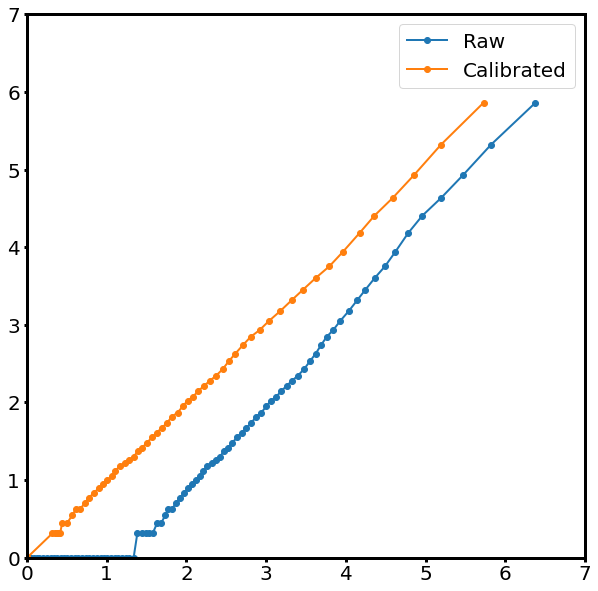

In [25]:
plt.figure(figsize=(10,10))
plt.rcParams.update({"font.size":20, "axes.linewidth":3, "xtick.major.width":3, "ytick.major.width":3})
plt.plot(sqrtqunat(modprecip['GEIRANGER']), sqrtqunat(obsprecip['GEIRANGER']), label="Raw", marker='o', linewidth=2)
plt.plot(sqrtqunat(qm), sqrtqunat(obsprecip['GEIRANGER']), label="Calibrated", marker='o', linewidth=2)
plt.xlim([0,7])
plt.ylim([0,7])
plt.legend()
plt.show()

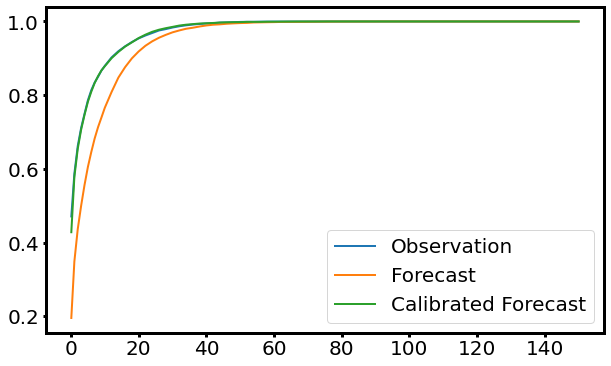

In [26]:
from nmc_met_base.qpf_cal import cum_freq

#
# calculate the CFD
obs_cfd, bins = cum_freq(obsprecip['GEIRANGER'])
fct_cfd, bins = cum_freq(modprecip['GEIRANGER'])
fct_cal_cfd, bins = cum_freq(qm)

#
# Compare the Observation and Forecasting CFD
plt.figure(figsize=(10,6))
plt.rcParams.update({"font.size":20, "axes.linewidth":3, "xtick.major.width":3, "ytick.major.width":3})
plt.plot(bins, obs_cfd, label="Observation", linewidth=2)
plt.plot(bins, fct_cfd, label="Forecast", linewidth=2)
plt.plot(bins, fct_cal_cfd, label="Calibrated Forecast", linewidth=2)
plt.legend()
plt.show()

## 频率匹配订正技术的业务应用
---

<img src="./images/freq_match_02.png" alt="image" style="height: 200px;">

## References

* Zhu, Y. J. and Y. Luo (2015). "Precipitation Calibration Based on the Frequency-Matching Method." weather and forecasting 30(5): 1109-1124.